Import des librairies nécessaires

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)

Un premier tensor avec 2 mots et une imbrication de niveau 5

In [6]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward>)


Dans l'exemple suivant, nous allons calculer la fonction de perte (loss) sur quelques exemples de formation et mettre à jour les paramètres avec la rétro-propropagation

In [7]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

In [8]:
test_sentence = """When forty winters shall besiege thy brow, And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now, Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies, Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes, Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use, If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,' Proving his beauty by succession thine!
This were to be new made when thou art old, And see thy blood warm when thou feel'st it cold.""".split()

Nous devrions tokeniser l'entrée (en créer des jetons), mais nous allons ignorer cela pour l'instant et construire une liste de **tuples** (collection ordonnée de n objets).

Chaque **tuple** est `([ word_i-2, word_i-1 ], mot_cible)`

In [9]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]

In [10]:
print(trigrams[:3]) # print the first 3, just so you can see what they look like

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]


In [11]:
vocab = set(test_sentence) # Le vocable à disposition (venant du texte fourni)

In [12]:
print(vocab)

{'the', 'thine!', 'proud', 'livery', 'Will', 'a', "totter'd", 'Then', 'own', 'Shall', 'dig', 'count,', 'asked,', 'see', 'make', 'succession', 'brow,', 'sum', 'winters', 'To', 'fair', "beauty's", 'use,', 'blood', 'praise.', 'by', 'couldst', "deserv'd", 'it', 'held:', 'be', 'thy', 'When', 'praise', 'warm', 'more', 'besiege', 'thou', 'made', 'old,', 'beauty', 'my', 'when', 'worth', 'lusty', 'and', 'old', 'gazed', 'so', 'eyes,', 'of', 'new', 'Thy', 'all-eating', 'weed', 'his', 'where', 'say,', 'thine', 'How', 'field,', 'days;', 'treasure', 'If', 'answer', 'small', 'Were', 'lies,', 'cold.', 'now,', 'shame,', 'And', 'deep', 'on', "youth's", 'mine', "feel'st", 'forty', 'thriftless', 'within', 'Proving', 'in', 'child', "excuse,'", "'This", 'were', 'being', 'shall', 'all', 'trenches', 'This', 'art', 'sunken', 'an', 'much', 'to', 'Where'}


In [13]:
word_to_ix = {word: i for i, word in enumerate(vocab)} # Le dictionnaire du vocable (lien mot => index)

In [14]:
print(word_to_ix)

{'the': 0, 'thine!': 1, 'proud': 2, 'livery': 3, 'Will': 4, 'a': 5, "totter'd": 6, 'Then': 7, 'own': 8, 'Shall': 9, 'dig': 10, 'count,': 11, 'asked,': 12, 'see': 13, 'make': 14, 'succession': 15, 'brow,': 16, 'sum': 17, 'winters': 18, 'To': 19, 'fair': 20, "beauty's": 21, 'use,': 22, 'blood': 23, 'praise.': 24, 'by': 25, 'couldst': 26, "deserv'd": 27, 'it': 28, 'held:': 29, 'be': 30, 'thy': 31, 'When': 32, 'praise': 33, 'warm': 34, 'more': 35, 'besiege': 36, 'thou': 37, 'made': 38, 'old,': 39, 'beauty': 40, 'my': 41, 'when': 42, 'worth': 43, 'lusty': 44, 'and': 45, 'old': 46, 'gazed': 47, 'so': 48, 'eyes,': 49, 'of': 50, 'new': 51, 'Thy': 52, 'all-eating': 53, 'weed': 54, 'his': 55, 'where': 56, 'say,': 57, 'thine': 58, 'How': 59, 'field,': 60, 'days;': 61, 'treasure': 62, 'If': 63, 'answer': 64, 'small': 65, 'Were': 66, 'lies,': 67, 'cold.': 68, 'now,': 69, 'shame,': 70, 'And': 71, 'deep': 72, 'on': 73, "youth's": 74, 'mine': 75, "feel'st": 76, 'forty': 77, 'thriftless': 78, 'within':

In [15]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [16]:
losses = []
loss_function = nn.NLLLoss()

In [17]:
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [18]:
print(model)

NGramLanguageModeler(
  (embeddings): Embedding(97, 10)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=97, bias=True)
)


In [19]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [20]:
for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)

In [21]:
print(losses)  # The loss decreased every iteration over the training data!

[520.6940414905548, 518.086208820343, 515.4969294071198, 512.9261291027069, 510.3733661174774, 507.83734250068665, 505.3165581226349, 502.8094666004181, 500.3153851032257, 497.8341701030731]


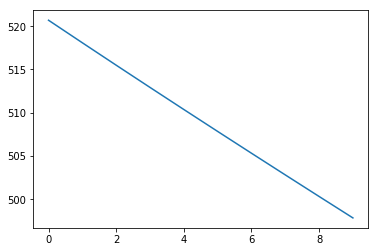

In [38]:
plt.plot(losses)